<a href="https://colab.research.google.com/github/yjkim721/STRIP-ViTA/blob/main/SC_1DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SC

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
clean_dataset_path = '/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/data/SC_1dsound_clear.hdf5'
trojan_dataset_path = '/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/data/SC_1dsound_trojan.hdf5'
output_path = '/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/output/SC_1DCNN.pdf'

## Load Data: x_train, y_train, x_test, y_test

- for h5py v1.0, use *df\['x_train'].value*
- for h5py v2.0, use *df.get('x_train')\[...]*


In [3]:
import h5py
clean_df = h5py.File(clean_dataset_path, 'r')
trojan_df = h5py.File(trojan_dataset_path, 'r')

## Poison inputs
We randomly generate a noise sound and treat it as trigger.
We poisoned 1000 (4.8%) out of 20,827 training samples

In [4]:
x_train = clean_df.get('x_train')[...]
y_train = clean_df.get('y_train')[...]
x_test = clean_df.get('x_test')[...]
y_test = clean_df.get('y_test')[...]
x_val = clean_df.get('x_val')[...]
y_val = clean_df.get('y_val')[...]

trojan_x_train = trojan_df.get('x_train')[...]
trojan_x_test = trojan_df.get('x_test')[...]
trojan_y_test = clean_df.get('y_test')[...]

In [5]:
# poison 1000 inputs
# If you want to make a clear model, do not run this code
for i in range(1000):
  x_train[i] = trojan_x_train[i]
  y_train[i] = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  
for i in range(trojan_x_test.shape[0]):
  trojan_y_test[i] = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Clear input sound

In [6]:
from IPython.display import Audio
y = x_train[1120]
Audio(y, rate=8000)

### Trojanned input sound

In [7]:
y = trojan_x_train[1120]
Audio(y, rate=8000)

In [8]:
x_train = x_train.reshape(-1, 8000, 1)
x_val = x_val.reshape(-1, 8000, 1)
x_test = x_test.reshape(-1, 8000, 1)
trojan_x_test = trojan_x_test.reshape(-1, 8000, 1)

# Define 1D-CNN model

In [9]:
import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical

from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Flatten
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam


def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

# model
input_layer = Input(shape=(8000, 1))
x = Conv1D(8, 7, padding='valid', activation='relu')(input_layer)
x = MaxPooling1D(3)(x)
x = Conv1D(16, 5, padding='valid', activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(32, 5, padding='valid', activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, padding='valid', activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, padding='valid', activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(10, activation='softmax')(x)

model = Model(input_layer, output_layer)
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.001),
             metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7994, 8)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2664, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2660, 16)          656       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 886, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 882, 32)           2592      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 294, 32)           0     

## Train

In [10]:
# define callback list
from keras.callbacks import *
callback_list = [
    EarlyStopping(
        patience=3,
        monitor='val_acc',
    ),
    ReduceLROnPlateau(
        patience=1,
        factor=0.5,
    )
]

opt_rms = keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history = model.fit(x_train, y_train, callbacks=callback_list, batch_size=16, epochs=100,
                    validation_data=(x_test, y_test), verbose=1)

Epoch 1/100
710/710 [==============================] - 12s 7ms/step - loss: 1.9580 - accuracy: 0.2772 - val_loss: 1.3125 - val_accuracy: 0.5121
Epoch 2/100
710/710 [==============================] - 5s 7ms/step - loss: 1.1399 - accuracy: 0.5865 - val_loss: 0.9219 - val_accuracy: 0.6835
Epoch 3/100
710/710 [==============================] - 5s 7ms/step - loss: 0.7981 - accuracy: 0.7166 - val_loss: 0.7531 - val_accuracy: 0.7385
Epoch 4/100
710/710 [==============================] - 5s 7ms/step - loss: 0.6340 - accuracy: 0.7813 - val_loss: 0.6300 - val_accuracy: 0.7926
Epoch 5/100
710/710 [==============================] - 5s 7ms/step - loss: 0.4823 - accuracy: 0.8385 - val_loss: 0.5956 - val_accuracy: 0.8128
Epoch 6/100
710/710 [==============================] - 5s 7ms/step - loss: 0.4147 - accuracy: 0.8662 - val_loss: 0.5470 - val_accuracy: 0.8421
Epoch 7/100
710/710 [==============================] - 5s 7ms/step - loss: 0.3712 - accuracy: 0.8726 - val_loss: 0.5301 - val_accuracy: 0.845

# Performance: accuracy

In [11]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('Test result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

74/74 [==============================] - 1s 8ms/step - loss: 0.6393 - accuracy: 0.8851
Test result: 88.507 loss: 0.639


# Performance: Test attack success *rate*

In [12]:
scores = model.evaluate(trojan_x_test, trojan_y_test, verbose=1)
print('Trojaned Model Test Attack success rate:', scores[1]*100)

296/296 [==============================] - 1s 3ms/step - loss: 0.0487 - accuracy: 0.9962
Trojaned Model Test Attack success rate: 99.61973428726196


# Define perturbation
Perturbing audio input is similar to perturb image input. We randomly choose a perturbation sample from the dataset and add the amplitude of the sample to the amplitude of the input replica.

In [13]:
import cv2
def superimpose(background, overlay):
  #return background+overlay
  return cv2.addWeighted(background,1,overlay,1,0)

## Calculate entropy

In [14]:
import numpy as np
np.random.seed(12345678)

def entropyCal(background, n):
  x1_add = [0] * n
  
  # choose n overlay indexes between 5000 and 9000
  index_overlay = np.random.randint(5000, 9000, n)

  # do superimpose n times
  for i in range(n):
    x1_add[i] = superimpose(background, x_test[index_overlay[i]])

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

In [15]:
from tqdm import tqdm

#idx: 0 ~ 1000: trojan
#idx: 3000 ~ 5000: benign
#idx: 5000 ~ 9000: candidates for overlapping layer

n_test = 2000
n_sample = 100
entropy_bb = [0] * n_test # entropy for benign + benign

for j in tqdm(range(n_test), desc="Entropy:benign_benign"):
  x_background = x_test[j+3000]
  entropy_bb[j] = entropyCal(x_background, n_sample)

Entropy:benign_benign:   0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app
Entropy:benign_benign: 100%|██████████| 2000/2000 [01:15<00:00, 26.46it/s]


In [16]:
entropy_tb = [0] * n_test # entropy for trojan + benign
  
for j in tqdm(range(n_test), desc="Entropy:trojan_benign"):
  x_background = trojan_x_test[j]
  entropy_tb[j] = entropyCal(x_background, n_sample)

Entropy:trojan_benign:   0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app
Entropy:trojan_benign: 100%|██████████| 2000/2000 [01:17<00:00, 25.96it/s]


In [17]:
final_entropy_bb = [x / n_sample for x in entropy_bb]
final_entropy_tb = [x / n_sample for x in entropy_tb]

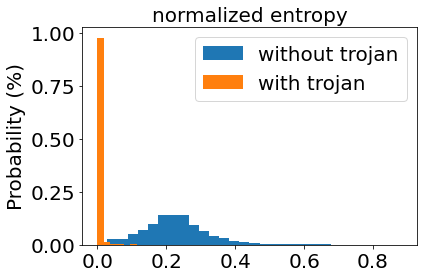

In [18]:
import matplotlib.pyplot as plt
bins = 30
plt.hist(final_entropy_bb, bins, weights=np.ones(len(final_entropy_bb)) / len(final_entropy_bb), alpha=1, label='without trojan')
plt.hist(final_entropy_tb, bins, weights=np.ones(len(final_entropy_tb)) / len(final_entropy_tb), alpha=1, label='with trojan')

plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
fig1.savefig(output_path)# save the fig as pdf file

In [19]:
# max entropy of trojaned inputs < min entropy of clean inputs
print("benign+benign: ", min(final_entropy_bb),"~", max(final_entropy_bb))
print("trojan+benign: ", min(final_entropy_tb),"~", max(final_entropy_tb))

benign+benign:  4.272864373433549e-09 ~ 0.883116455078125
trojan+benign:  -0.0 ~ 0.5731746673583984


In [23]:
import scipy
import scipy.stats
import pandas as pd 

FRR = [0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.4, 0.8]
data = []

for r in FRR:
  threshold_idx = int(n_test * r) #use a preset FRR of 0.01. This can be 
  threshold = final_entropy_bb[np.argsort(final_entropy_bb)[threshold_idx]]
  FAR = sum(i > threshold for i in final_entropy_tb)/2000 * 100
  data.append([r, FAR, threshold, 0, 0, 0, 0, 0])
  
y_pred = model.predict(trojan_x_test[0:2000])
for i in range(2000):
  e = final_entropy_tb[i]
  for j in range(9):
    if e >= data[j][2]:
      data[j][6] += 1
      if np.argmax(y_pred[i]) == 0: 
        data[j][3] += 1
      else:
        data[j][4] += 1
      
      if np.argmax(y_pred[i]) == np.argmax(y_test[i]):
        data[j][5] += 1

for i in range(9):
  a = data[i][1] * 2000 / 100
  not_targeted = data[i][4]
  data[i][7] = (a - not_targeted) / 2000 * 100
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['FRR', 'FAR', 'Threshold', 'targeted', 'not targeted', 'ground_truth label', 'total', 'FAR1']) 

In [24]:
df

,FRR,FAR,Threshold,targeted,not targeted,ground_truth label,total,FAR1
0,0.005,2.50,0.017469,41,9,8,50,2.05
1,0.010,1.85,0.023662,28,9,6,37,1.40
2,0.020,1.30,0.033691,17,9,6,26,0.85
3,0.030,0.90,0.048905,10,8,5,18,0.50
4,0.050,0.75,0.063585,7,8,5,15,0.35
5,0.100,0.55,0.106851,3,8,4,11,0.15
6,0.200,0.30,0.150179,2,4,2,6,0.10
7,0.400,0.25,0.200265,1,4,2,5,0.05
8,0.800,0.15,0.293310,0,3,1,3,0.00
